# 001b Friedel pairs Batch

Run find_friedel_pairs.py to match friedel pairs for a series of datasets. Use parallelization for faster computation. Parameters for friedel pair search are edited directly in the script file (find_friedel_pairs.py)

In [4]:
import os, sys
import pylab as pl
import numpy as np
from pprint import pprint

import ImageD11.sinograms.dataset, ImageD11.columnfile

if '/home/esrf/jean1994b/' not in sys.path:
    sys.path.append('/home/esrf/jean1994b/')
    
from pf_3dxrd import utils, friedel_pairs, crystal_structure

%matplotlib ipympl
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Build commands

In [39]:
# paths
data_dir = 'data'                           # folder containing your data
parfile='data/SI3.par'                      # parameter file
splinefile = 'data/frelon21_mar16.spline'   # spline file for detector distortion (frelon)

# list of datasets to process
dset_list = ['SI3_DT360Z5480']                   

In [5]:
# functions to get path names from dataset name
def get_pkspath(dsname):
    return os.path.join(data_dir, dsname+'_pks.h5')

def get_dspath(dsname):
    return os.path.join(data_dir, dsname+'_dataset.h5')

In [18]:
# have a look at options in find_friedel_pairs.py and update them if needed. Edit them directly in the file

with open('find_friedel_pairs.py','r') as f:
    print_lines = False
    for l in f.readlines():
        if 'class Options' in l:
            print_lines = True
            continue
        if 'END EDITABLE' in l:
            print_lines = False
            break
            
        if print_lines:
            print(l, end='')


    ## PAIRING OPTIONS
    dist_max  = 1.5      # max distance for nearest-neighbour search
    dist_step = 0.1      # distance step incrrase at each iteration
    sf_tth    = 1.       # scale factor two-theta
    sf_I      = 1.       # scale factor sum intensity
    
    ## PEAKS FILTERING
    # before Friedel pair matching: remove weak peaks (background noise) + suspiciously strong peaks
    Npx_min   = 3        # min nb of pixels
    sumI_min  = 30       # min sum_intensity 
    sumI_max  = 1e7      # max sum_intensity
    
    # after Friedel pairs identification. screen out dodgy friedel pairs from the output
    max_tth_dist   = 1.     # max two-theta angle between two peaks in a pair (degree) 
    max_eta_dist   = 1.     # max eta angle between two peaks in a pair (degree) 
    max_omega_dist = 1.     # max omega angle between two peaks in a pair (degree) 
    max_logI_dist  = 1.     # max intensity difference (in log units) between two peaks in a pair
    
    # MULTIPROCESSING

In [34]:
# prepare commands run to find_friedel_pairs.py

def get_command(dsname):
    pksfile = get_pkspath(dsname)
    dsfile = get_dspath(dsname)
    
    command = f'./find_friedel_pairs.py -pksfile {pksfile} -dsfile {dsfile} -parfile {parfile} -splinefile {splinefile}'\
    f' -use2Dpeaks False'
    
    return command


jobs = [get_command(dsname)]

jobs[0]

'./find_friedel_pairs.py -pksfile data/SI3_DT360Z5480_pks.h5 -dsfile data/SI3_DT360Z5480_dataset.h5 -parfile data/SI3.par -splinefile data/frelon21_mar16.spline -use2Dpeaks False'

### Submit jobs

In [ ]:
for j in jobs:
    !python {j}


### Look at outputs

CS: quartz, phase_id: 0, spg: P3221, spg_no: 154, lattice: [  4.91325   4.91325   5.41206  90.       90.      120.     ]
CS: orthoclase, phase_id: 1, spg: C1-11, spg_no: 12, lattice: [  8.589  13.013   7.197  90.    116.02   90.   ]
CS: oligoclase, phase_id: 2, spg: C-1, spg_no: 2, lattice: [  8.154  12.823   7.139  94.06  116.5    88.59 ]
CS: biotite, phase_id: 3, spg: C12/m1, spg_no: 12, lattice: [  5.355   9.251  10.246  90.    100.15   90.   ]
CS: magnetite, phase_id: 4, spg: Fd3m, spg_no: 227, lattice: [ 8.3965  8.3965  8.3965 90.     90.     90.    ]
Scatter(quartz with 2 atomic positions, 6 symmetries)
       Type: x-ray
     Energy: 43.57356018082551 keV
 Wavelength: 0.28454050670689945 A
 ---Settings---
      Powder units: tth
    Isotropic ADPs: True
  Specular Direction (reflection): ( 0, 0, 1)
Parallel Direction (transmission): ( 0, 0, 1)
      theta offset: 0.0
         min theta: -180.0
         max theta: 180.0
      min twotheta: 0
      max twotheta: 15
 ---X-Ray Setti

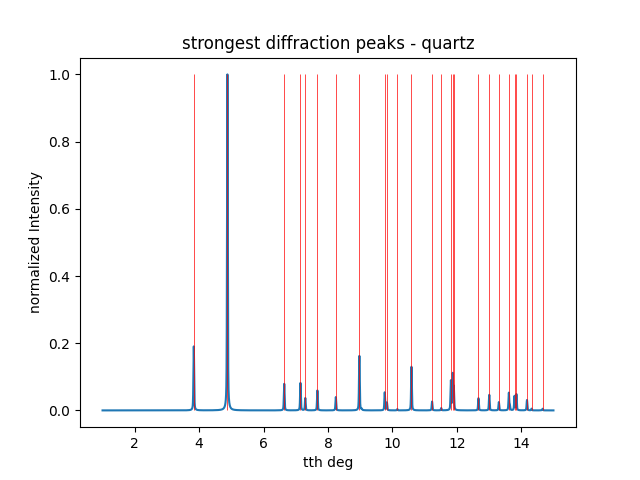

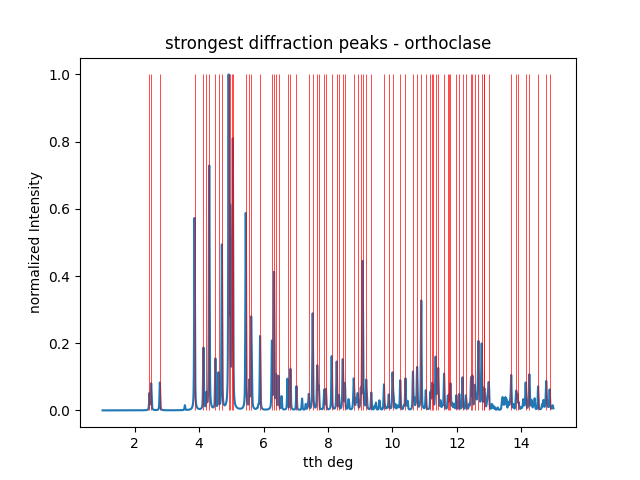

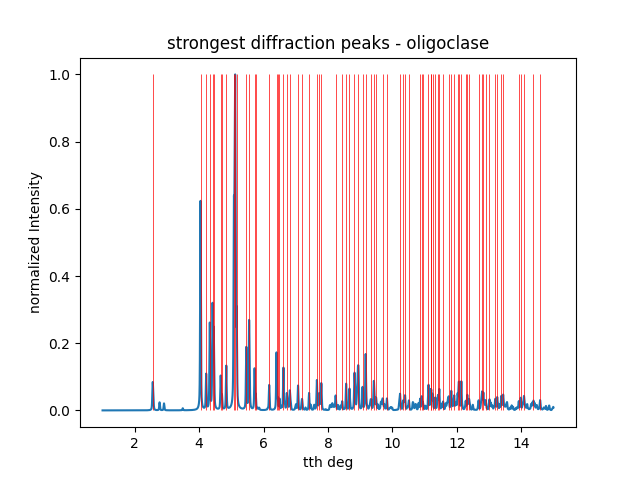

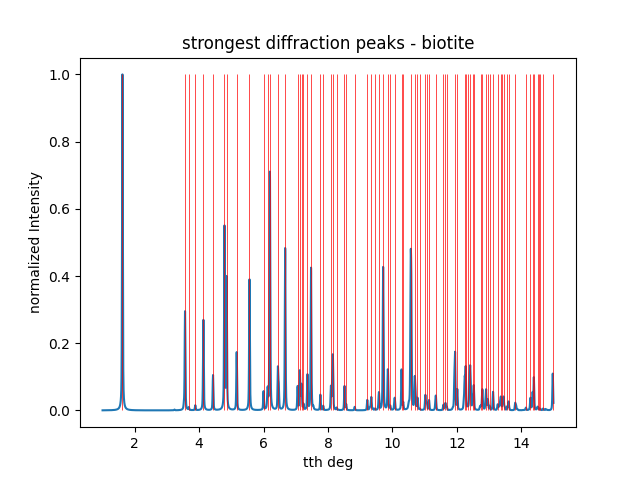

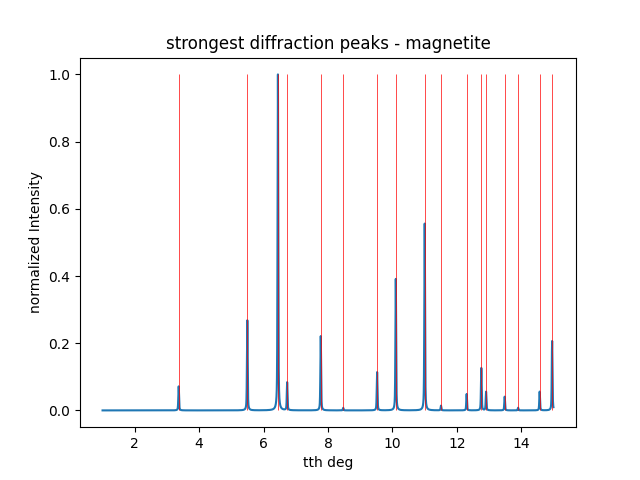

In [70]:
# define a dictionary with all  phases. Here we assume that we already know what are the phases in the sample, but it might be something we want to determine as well
phase_names = ['quartz','orthoclase','oligoclase','biotite','magnetite']
phase_dict = {}

for i,p in enumerate(phase_names):
    cs = crystal_structure.load_CS_from_cif(cif_path = f'cif/{p}.cif', name=p, pid=i)
    print(cs)
    phase_dict[p] = cs
    
pars = ImageD11.parameters.read_par_file(parfile)
wl = pars.get('wavelength')   # from parameter file

# compute theoretical 2θ rings: compute a simulated powder spectrum, and then we run a peaksearch on this spectrum to find the N-strongest peaks.
# This allows to retain only the most significant peaks, and not care about all the numerous, very low intensity peaks which theoretically exist but 
#are practically barely visible.

for cs in phase_dict.values():
    cs.compute_powder_spec(wl, min_tth=0, max_tth=15, doplot=False)
    cs.find_strongest_peaks(Imin=0.001, prominence=0.001, Nmax=80, doplot=True)

In [78]:
def load_paired_pksfile(dsname):
    pksfile = get_pkspath(dsname).replace('.h5','_p.h5')
    dsfile = get_dspath(dsname)
    
    cf = ImageD11.columnfile.columnfile(pksfile)
    ds = ImageD11.sinograms.dataset.load(dsfile)
    
    cf.parameters.loadparameters(parfile)
    cf.updateGeometry()
    friedel_pairs.update_geometry_s3dxrd(cf, ds, update_gvecs=True)
    
    return cf, ds


def make_plots(cf, ds, **kw):
    fig = pl.figure(figsize=(10,10))
    
    fig.add_subplot(221)
    pl.hist(cf.fp_dist,100);
    pl.xlabel('fp_dist')
    
    fig.add_subplot(222)
    r = utils.friedel_recon(cf, ds.ybinedges, ds.ybinedges, mask=None, weight_by_intensity=True, norm=True, doplot=False)
    pl.pcolormesh(ds.ybinedges, ds.ybinedges, r, **kw)
    
    fig.add_subplot(212)
    h,b,_ = utils.compute_tth_histogram(cf, tthmin=0, tthmax=15, tthstep=0.0005, density=True, use_tthc=False, uself=True)
    hc,bc,_ = utils.compute_tth_histogram(cf, tthmin=0, tthmax=15, tthstep=0.0005, density=True, use_tthc=True, uself=True)
    
    pl.plot(b,h, ls='dotted', color='darkgrey', lw=.8, label='uncorrected tth')
    pl.plot(bc,hc,ls='-',color='dimgrey', lw=1., label ='corrected tth')
    
    for cs in phase_dict.values():
        pl.vlines(cs.strong_peaks[0], -1, 0, colors=cs.color, label = cs.name)
    pl.xlabel('tth deg')
    pl.legend()
    
    fig.suptitle(ds.dsname)

In [72]:
# reload paired peakfiles 
pksfiles = []
dsfiles = []

for d in dset_list:
    cf, ds = load_paired_pksfile(d)
    pksfiles.append(cf)
    dsfiles.append(ds)

Reading your columnfile in hdf format


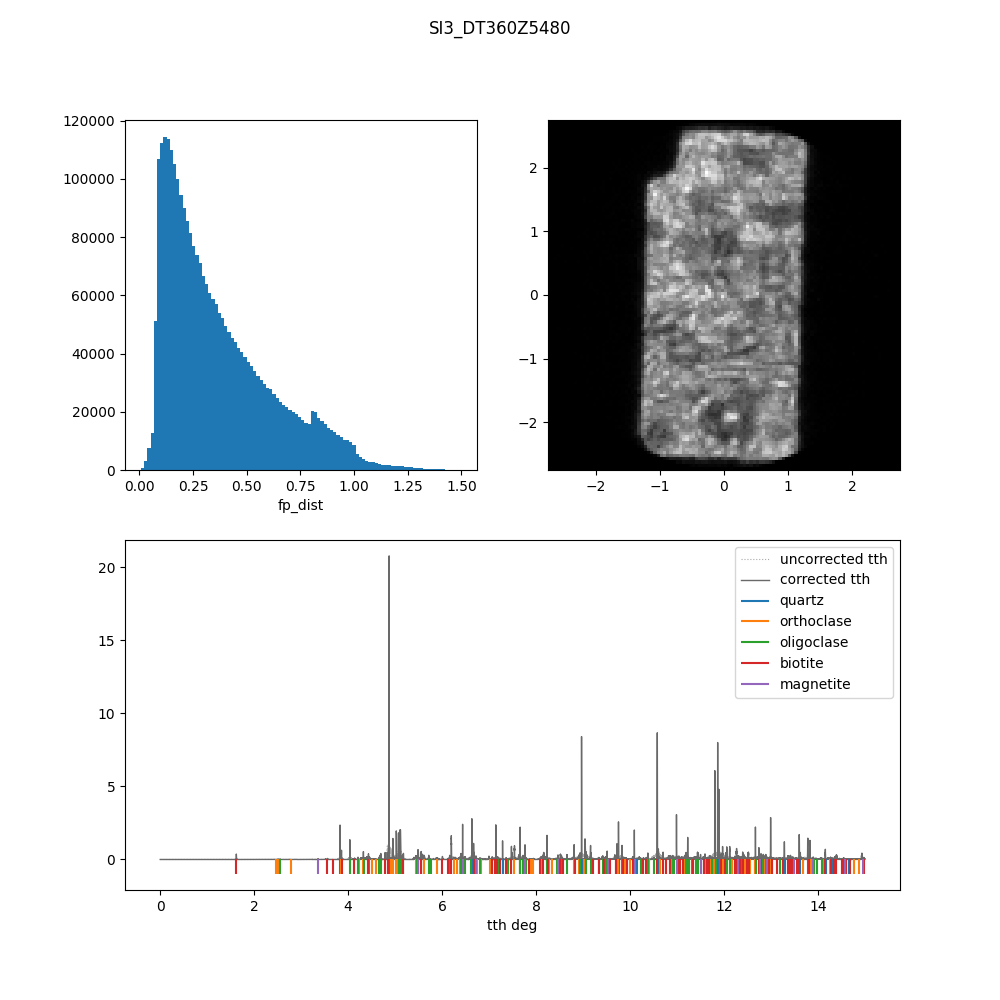

In [79]:
# make plots
kw = {'cmap': 'Greys_r', 'vmin':0, 'vmax':1}

for cf, ds in zip(pksfiles,dsfiles):
    make_plots(cf, ds,**kw)

In [82]:
dsfiles.index(ds)

0

/tmp/ipykernel_3562520/2403779382.py:21: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  pl.colorbar(sm, label='dataset index')
/tmp/ipykernel_3562520/2403779382.py:36: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  pl.colorbar(sm, label='dataset index')


Text(0.5, 0.98, 'SI3')

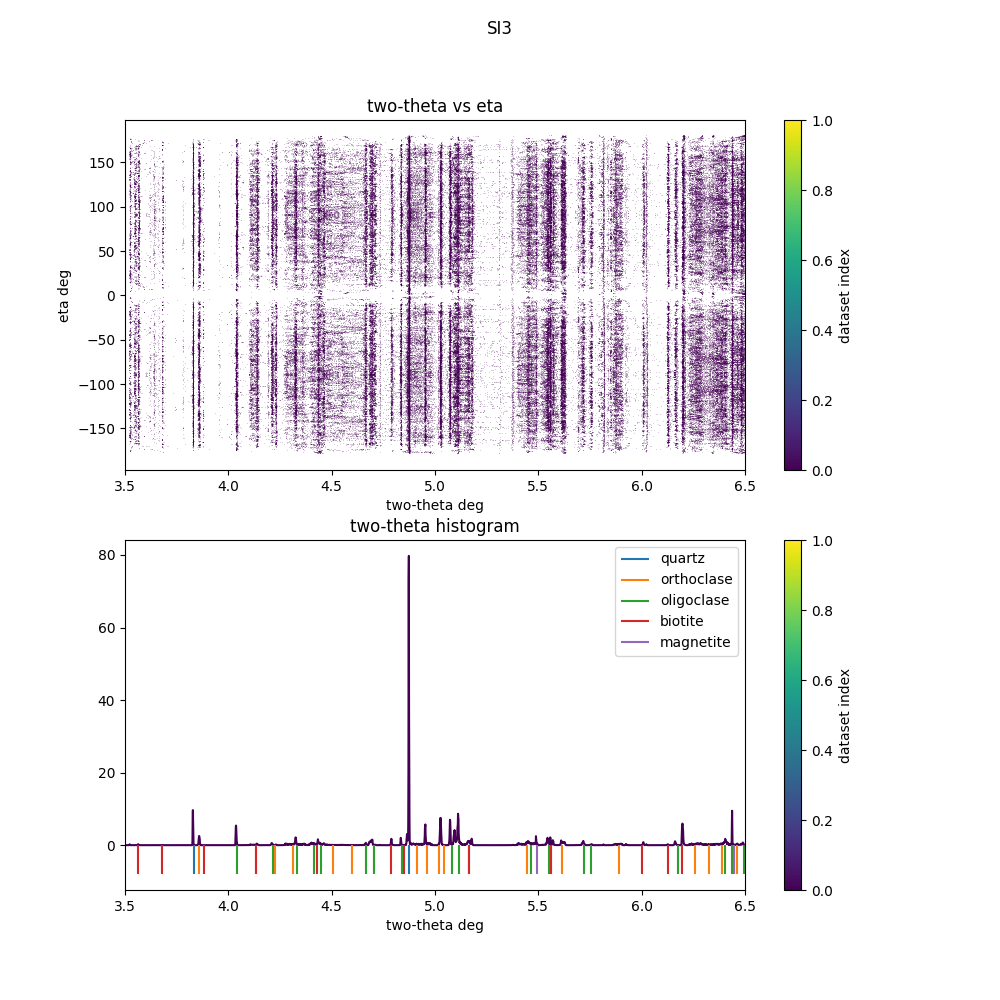

In [84]:
# stack all tth hist on one splot
pl.close('all')

# colormap to color plots by dataset index
cmap = pl.matplotlib.cm.viridis.copy()
norm=pl.matplotlib.colors.Normalize(vmin=0, vmax=len(dset_list))

sm = pl.matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# plot
tthmin, tthmax  = 3.5,6.5
fig = pl.figure(figsize=(10,10))

fig.add_subplot(211)
for cf, ds in zip(pksfiles,dsfiles):
    dset_indx = dsfiles.index(ds)
    m = np.all([cf.tthc <= tthmax, cf.tthc>=tthmin], axis=0)
    pl.plot(cf.tthc[m],cf.eta[m],',', color=cmap(norm(dset_indx)), alpha=.2)
    
pl.colorbar(sm, label='dataset index')
pl.title('two-theta vs eta')
pl.xlabel('two-theta deg')
pl.ylabel('eta deg')
pl.xlim(tthmin,tthmax)
    
fig.add_subplot(212)
for cf, ds in zip(pksfiles,dsfiles):
    dset_indx = dsfiles.index(ds)
    h,b,_ = utils.compute_tth_histogram(cf, use_tthc=True, tthmin=tthmin, tthmax=tthmax, tthstep=0.001, density=True, uself=True)
    pl.plot(b,h, color=cmap(norm(dset_indx)))
    
for cs in phase_dict.values():
    pl.vlines(cs.strong_peaks[0], -.1*h.max(), 0, colors=cs.color, label=cs.name)

pl.colorbar(sm, label='dataset index')
pl.legend()
pl.title('two-theta histogram')
pl.xlabel('two-theta deg')
pl.xlim(tthmin,tthmax)
fig.suptitle(ds.sample)